# Imports

In [43]:
from torchqrnn import QRNN

In [2]:
import numpy as np

from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU, Conv1d
from torch.nn.functional import softmax, relu

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

DATA_DIRECTORY = "data/"

In [3]:
# torch.backends.cudnn.enabled=False

In [4]:
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(use_cuda)

True


In [6]:
id_seqs = {str(i):[] for i in range(6)}
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    for line in fIn :
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0][-1200:])

In [7]:
print(len(id_seqs['0']))
print(len(id_seqs['3']))

3486
2874


In [9]:
import random

In [10]:
seq_0 = random.sample(id_seqs['0'],200)
seq_3 = random.sample(id_seqs['3'],200)

In [11]:
with open('train_mini_0and3.txt','w') as fOut : 
    for seq in seq_0 : 
        fOut.write(seq + "," + "0\n")
    for seq in seq_3 : 
        fOut.write(seq + "," + "3\n") 

In [12]:
a = [1,2,3]
print(a[-2:])

[2, 3]


## taking only 500 first nucleotids

In [13]:
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'train_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [14]:
with open(DATA_DIRECTORY+'test_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'test_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [15]:
with open(DATA_DIRECTORY+'val_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'val_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [16]:
dic = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
with open(DATA_DIRECTORY+'val_filtered_reduced.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        dic[line[1].strip()] +=1 

In [17]:
dic

{'0': 497, '1': 788, '2': 114, '3': 410, '4': 229, '5': 46}

In [18]:
[i/sum(dic.values()) for i in dic.values()]

[0.23848368522072938,
 0.3781190019193858,
 0.05470249520153551,
 0.1967370441458733,
 0.10988483685220729,
 0.022072936660268713]

In [20]:
t = 0
nb0 = 0
for i in validation_set:
    t += 1 
    if i.label=='0' : 
        nb0 += 1
print(t,nb0)

NameError: name 'validation_set' is not defined

In [21]:
t = 0
nb0 = 0
for i in validation_iter:
    t += len(i.label)
    nb0 += int(sum(i.label==0))

print(t,nb0)

NameError: name 'validation_iter' is not defined

In [22]:
L = sum([value for value in dic.values()])
print(L)
print(3586/14626)

2084
0.24517981676466566


# Torchtext dataloader 

In [23]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

#Load the data
# train_set, validation_set, test_set = data.TabularDataset.splits(path='',
#                                                                  train='train_filtered.txt',
#                                                                  validation='test_filtered.txt',
#                                                                  test='test_filtered.txt', 
#                                                                  format = 'csv',
#                                                                  fields=[('sequence', SEQ), ('label', LABEL)])

train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train='train_mini_0and3.txt',
                                                                 validation='train_mini_0and3.txt',
                                                                 test='train_mini_0and3.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

In [24]:
for i in train_set : 
    print(i.label)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 399.]),
 array([481. , 492.9, 504.8, 516.7, 528.6, 540.5, 552.4, 564.3, 576.2,
        588.1, 600. ]),
 <a list of 10 Patch objects>)

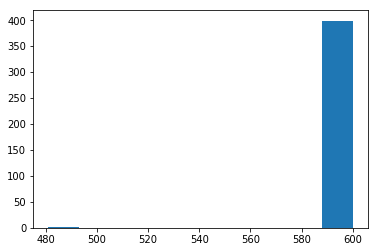

In [25]:
L = [len(train_set[i].sequence) for i in range(len(train_set))]
plt.hist(L)


In [26]:
print('train_set.fields:', list(train_set.fields.keys()))
print('validation_set.fields:', list(validation_set.fields.keys()))
print('test_set.fields:', list(test_set.fields.keys()))
print()
print('size of training set', len(train_set))
print('size of validation set', len(validation_set))
print()
print('content of first training sample:')
print(vars(train_set[0]))

train_set.fields: ['sequence', 'label']
validation_set.fields: ['sequence', 'label']
test_set.fields: ['sequence', 'label']

size of training set 400
size of validation set 400

content of first training sample:
{'sequence': ['G', 'G', 'A', 'G', 'G', 'T', 'G', 'A', 'T', 'T', 'G', 'C', 'T', 'C', 'A', 'T', 'A', 'T', 'A', 'G', 'C', 'A', 'A', 'G', 'A', 'A', 'G', 'G', 'A', 'C', 'T', 'G', 'T', 'C', 'A', 'C', 'T', 'C', 'T', 'G', 'C', 'C', 'T', 'G', 'G', 'T', 'C', 'A', 'C', 'C', 'T', 'T', 'A', 'C', 'T', 'G', 'C', 'T', 'G', 'A', 'T', 'T', 'G', 'G', 'C', 'T', 'G', 'T', 'C', 'T', 'G', 'C', 'T', 'C', 'A', 'C', 'C', 'T', 'T', 'A', 'T', 'T', 'G', 'C', 'C', 'A', 'A', 'T', 'T', 'G', 'G', 'C', 'T', 'G', 'T', 'T', 'A', 'A', 'G', 'A', 'G', 'A', 'C', 'T', 'G', 'T', 'G', 'G', 'A', 'C', 'A', 'G', 'C', 'A', 'A', 'G', 'G', 'G', 'C', 'A', 'A', 'C', 'T', 'C', 'C', 'A', 'G', 'A', 'T', 'G', 'T', 'T', 'C', 'C', 'A', 'G', 'A', 'A', 'A', 'G', 'A', 'G', 'G', 'A', 'G', 'A', 'G', 'G', 'C', 'C', 'T', 'C', 'T', 'G', 'T',

In [27]:
# build the vocabularies
SEQ.build_vocab(train_set) #NO unknows 
LABEL.build_vocab(train_set)

In [28]:
print('Text fields:')
print(' size of vocabulary:', len(SEQ.vocab))
# print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ.vocab.freqs['N'])
print(" list of vocabulary (int-to-str):", SEQ.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(SEQ.vocab.stoi))
print(SEQ.vocab.freqs)
print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))
print(LABEL.vocab.freqs)

Text fields:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 0
 list of vocabulary (int-to-str): ['N', '<pad>', 'T', 'A', 'G', 'C']
 list of vocabulary (str-to-int): {'N': 0, '<pad>': 1, 'T': 2, 'A': 3, 'G': 4, 'C': 5}
Counter({'T': 69104, 'A': 69033, 'G': 51525, 'C': 50218})

Label fields:
 list of vocabulary (int-to-str): ['1', '0', '3']
 list of vocabulary (str-to-int): {'1': 0, '0': 1, '3': 2}
Counter({'0': 200, '3': 200})


In [29]:

weight = [i/sum(dic.values()) for i in dic.values()]
weight_square = [i**2 for i in weight]
weight_square = torch.FloatTensor(weight_square).cuda()
weight_square = 1 - weight_square/sum(weight_square)


final_weights = torch.FloatTensor([weight_square[int(i)] for i in LABEL.vocab.itos]).cuda()
print(final_weights)

tensor([0.4373, 0.7762, 0.8477], device='cuda:0')


In [30]:
[i/sum(dic.values()) for i in dic.values()]

[0.23848368522072938,
 0.3781190019193858,
 0.05470249520153551,
 0.1967370441458733,
 0.10988483685220729,
 0.022072936660268713]

In [31]:
# make iterator for splits
# train_iter, val_iter = data.BucketIterator.splits((train_set, validation_set),
#                                                      batch_size=128, 
#                                                      device=0 if use_cuda else -1,
#                                                      sort_key=lambda x: len(x.sequence), #Sorting within the batch
#                                                      sort_within_batch=False,
#                                                      repeat=False)

BATCH_SIZE = 20

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                 sort = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


In [32]:
for i in train_iter : 
    print(i.label)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1],
 

In [48]:
# size of embeddings
EMBEDDING_DIM = 100
NUM_EMBEDDING = len(SEQ.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
HIDDEN_DIM = 111
NUM_LAYERS_LSTM = 1
SEQ_LEN = len(train_set[0].sequence)
print(SEQ_LEN)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden_dim = HIDDEN_DIM
        
        #learn a new embedding
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)

        # use pretrained embeddings
        
        self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=3,
                            stride=3)
        
        #self.lstm = LSTM(input_size=EMBEDDING_DIM,
        #                 hidden_size=HIDDEN_DIM,
        #                 num_layers=NUM_LAYERS_LSTM,
        #                 bidirectional=False)
        
        self.qrnn = QRNN(EMBEDDING_DIM, HIDDEN_DIM, num_layers=1, dropout=0.4)
        self.qrnn.cuda()
        
        # link hidden to tag 
        self.hidden2tag = Linear(in_features=HIDDEN_DIM,
                            out_features=NUM_CLASSES,
                            bias=False)
        
        
        #init lstm hidden units 
        self.hidden = self.init_hidden(BATCH_SIZE)
        
    def forward(self, x):
        sequences = x[0]
        lengths = x[1]
#         out = {}
        batch_size = sequences.size()[1]
        # get embeddings
        embeds = self.embeddings(sequences)
        
        embeds = embeds.permute([1,2,0])
        embeds = self.conv1(embeds)
        embeds = embeds.permute([2,0,1])
        
        #embeds = nn.utils.rnn.pack_padded_sequence(embeds,lengths/3, batch_first=False)
        # rnn returns output and last hidden state
        lstm_out, self.hidden = self.qrnn(embeds)
        #lstm_out, self.hidden = self.lstm(embeds)
        #unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=False)
        unpacked = lstm_out
        last_output = unpacked[-1].type(torch.float)
        
        
        tag_space = self.hidden2tag(last_output)
        tag_scores = softmax(tag_space)
        return tag_scores
    
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, self.hidden_dim),
                torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, self.hidden_dim))

net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

600
using cuda
Net(
  (embeddings): Embedding(6, 100)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(3,))
  (qrnn): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=100, out_features=333, bias=True)
      )
    )
  )
  (hidden2tag): Linear(in_features=111, out_features=3, bias=False)
)


In [49]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

{'embeddings.weight': True,
 'conv1.weight': True,
 'conv1.bias': True,
 'qrnn.layers.0.linear.weight': True,
 'qrnn.layers.0.linear.bias': True,
 'hidden2tag.weight': True}

In [50]:
criterion = nn.CrossEntropyLoss() #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.1)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [51]:
num_epoch = 5
iter_by_epoch = int(len(train_set)/BATCH_SIZE)
eval_every = 1
train_loss, train_accs = [], []
valid_loss, valid_accs = [], []
valid_iter = []

for epoch in range(num_epoch):
    print("["+str(epoch)+"]"+"="*epoch)
    running_loss = 0.0
    net.train()
    # Training
    for i, batch in enumerate(train_iter):
#         print("batch "+ str(i))
#         if i % eval_every == 0:
#             valid_iter.append(i + (1+epoch)*iter_by_epoch)
#             net.eval()
#             val_losses, val_accs, val_lengths = 0, 0, 0
            
#             for val_batch in validation_iter:
#                 output = net(val_batch.sequence)
#                 val_losses += criterion(output, val_batch.label)*val_batch.batch_size
#                 val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
#                 val_lengths += val_batch.batch_size

#             # divide by the total accumulated batch sizes
#             val_losses /= val_lengths
#             val_accs /= val_lengths
#             valid_loss.append(get_numpy(val_losses))
#             valid_accs.append(get_numpy(val_accs))
#             net.train()
            
            
        optimizer.zero_grad()

        output = net(batch.sequence)
        batch_loss = criterion(output, batch.label)

        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output, batch.label)))


        batch_loss.backward()
        optimizer.step()

# 500, 20, 100/



[0]


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1162: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttributeError: 'bytes' object has no attribute 'encode'

In [37]:
for i in train_iter : 
    print(i.label)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1],
 

In [38]:
valid_iter = [i - 112 for i in valid_iter]

In [39]:
train_loss_red = []
little = []
compt = 1
for i in train_loss : 
    little.append(i)
    if compt%100 == 0:
        print(compt)
        train_loss_red.append(np.mean(little))
        little = []
    compt+=1

100


In [40]:
np.mean(train_accs[:-100])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

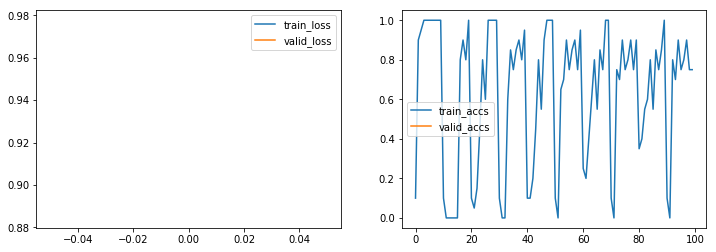

In [41]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_red, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.legend()
plt.show()


In [293]:
torch.max(output,1)[1]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3], device='cuda:0')

In [356]:
net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []
for val_batch in train_iter:
    output = net(val_batch.sequence)
    predictions += [int(i) for i in torch.max(output,1)[1]]
    real_values += [int(i) for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    print(accuracy(output, val_batch.label) *val_batch.batch_size, val_batch.batch_size)
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

print("[%i]"%get_numpy(val_accs), val_lengths, val_accs)
# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
print("[%i]"%get_numpy(val_accs))
net.train()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(15., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(17., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
[387] 400 tensor(387., device='cuda:0')
[0]


Net(
  (embeddings): Embedding(6, 100)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(3,))
  (lstm): LSTM(100, 111)
  (hidden2tag): Linear(in_features=111, out_features=3, bias=False)
)

In [357]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [358]:
output

tensor([[8.3939e-07, 7.8227e-04, 9.9922e-01],
        [1.1353e-06, 7.3812e-05, 9.9993e-01],
        [8.5646e-06, 1.8252e-03, 9.9817e-01],
        [6.4346e-06, 3.1196e-03, 9.9687e-01],
        [2.4455e-04, 4.5467e-03, 9.9521e-01],
        [4.9675e-06, 8.7108e-04, 9.9912e-01],
        [1.5768e-05, 1.5943e-03, 9.9839e-01],
        [1.4948e-04, 2.4624e-03, 9.9739e-01],
        [1.3874e-05, 2.1734e-03, 9.9781e-01],
        [2.4438e-06, 5.0490e-05, 9.9995e-01],
        [3.6360e-06, 8.7438e-05, 9.9991e-01],
        [1.6291e-05, 2.7198e-03, 9.9726e-01],
        [1.5844e-05, 4.1070e-04, 9.9957e-01],
        [6.0377e-06, 1.4313e-03, 9.9856e-01],
        [7.8869e-06, 1.8403e-03, 9.9815e-01],
        [1.8819e-05, 1.8621e-03, 9.9812e-01],
        [1.2744e-05, 1.2774e-04, 9.9986e-01],
        [4.6169e-06, 4.3788e-03, 9.9562e-01],
        [1.7736e-05, 1.7656e-03, 9.9822e-01],
        [1.4403e-05, 8.0118e-05, 9.9991e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [359]:
from sklearn.metrics import confusion_matrix
import itertools

In [360]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



Normalized confusion matrix
[[ nan  nan  nan]
 [0.01 0.97 0.02]
 [0.01 0.02 0.96]]


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


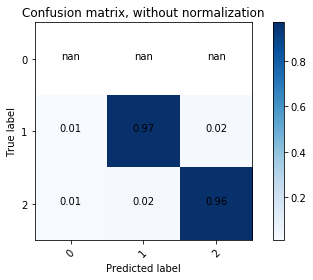

In [361]:
cnf_matrix = confusion_matrix(real_values, predictions)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classes = [str(i) for i in range(NUM_CLASSES)]
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, without normalization', normalize=True)


plt.show()
